# Natural Language Processing

In [1]:
import os
import requests
import pandas as pd 
import numpy as np
import csv
import sys

csv.field_size_limit(sys.maxsize)

reviews = "/Users/skhederian/restaurant-health/format_reviews.csv"
data = "/Users/skhederian/restaurant-health/the_final_countdown.csv"

dfr = pd.read_csv(reviews)
dfd = pd.read_csv(data)

In [2]:
#Drop NaN Violations
dfreview = dfr.dropna(how = 'any').copy()
dfreview.shape

(20377, 5)

In [3]:
#Remove outliers that have high violation (> 4 standard deviations)
o = dfreview.copy()
odf = o[((o.violations - o.violations.mean()) / o.violations.std()).abs() < 4]
odf.shape

(20248, 5)

In [4]:
#Create bins for violation counts
bins = [-1, 5, 10, 15, 20, 25, 30, 35, 40]
group_names = ['Perfect', 'Excellent', 'Great', 'Good', 'Bad', 'Very Bad', 'rats', 'Shutdown']

odf['violationoutcat'] = pd.cut(odf['violations'], bins, labels=group_names)
odf.head()
odf.shape

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(20248, 6)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(analyzer='word', ngram_range=(1,3), min_df = .25, stop_words = 'english')
counts = cv.fit_transform(odf['string_agg'].values)
counts

<20248x163 sparse matrix of type '<class 'numpy.int64'>'
	with 1212134 stored elements in Compressed Sparse Row format>

In [6]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()

targetout = odf.violationoutcat.values
classifier.fit(counts, targetout)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [8]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vectorizer',  cv),
    ('classifier',  classifier) ])

In [12]:
from sklearn.cross_validation import KFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


k_fold = KFold(n=len(odf), n_folds=12)
f1scores = []
ascores = []
rscores = []
pscores = []

for train_indices, test_indices in k_fold:
    train_text = odf.iloc[train_indices]['string_agg'].values
    train_y = odf.iloc[train_indices]['violationoutcat'].values

    test_text = odf.iloc[test_indices]['string_agg'].values
    test_y = odf.iloc[test_indices]['violationoutcat'].values

    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)

    #scores
    f1score = f1_score(test_y, predictions, average='weighted')
    f1scores.append(f1score)
    accuracy = accuracy_score(test_y, predictions)
    ascores.append(accuracy)
    recall = recall_score(test_y, predictions, average='weighted')
    rscores.append(recall)
    precision = precision_score(test_y, predictions, average='weighted')
    pscores.append(precision)

In [13]:
print('Total reviews classified:', len(odf))
print('F1 Score:', sum(f1scores)/len(f1scores))
print ('Accuracy:', sum(ascores)/len(ascores))
print ('Recall:', sum(rscores)/len(rscores))
print ('Precision:', sum(pscores)/len(pscores))

Total reviews classified: 20248
F1 Score: 0.445163497273
Accuracy: 0.447502934577
Recall: 0.447502934577
Precision: 0.447292325052


In [ ]:
#Create a Pickle
from sklearn.externals import joblib

joblib.dump(pipeline, 'class.pkl', compress=9)

# Text Features

In [10]:
def most_informative_feature_for_class(cv, classifier, classlabel, n=30):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = cv.get_feature_names()
    topn = sorted(zip(classifier.coef_[labelid], feature_names)) [-n:]
    
    for coef, feat in topn:
        print (classlabel, feat, coef)

In [12]:
most_informative_feature_for_class(cv, classifier1, 'rats')

rats did -4.80834203911
rats didn -4.80834203911
rats definitely -4.77130076743
rats love -4.73558268483
rats came -4.70109650876
rats delicious -4.68428939044
rats eat -4.65149956762
rats menu -4.65149956762
rats pretty -4.6197508693
rats rice -4.58897921064
rats try -4.55912624749
rats little -4.51595407562
rats nice -4.44790061238
rats got -4.42192512597
rats best -4.39660731799
rats ve -4.38418479799
rats don -4.35979334487
rats order -4.34781715382
rats restaurant -4.34781715382
rats ordered -4.26777444615
rats chicken -4.24603445951
rats time -4.09650272554
rats really -4.06013508137
rats just -3.9344468662
rats great -3.92660368874
rats service -3.9188215483
rats like -3.77468764672
rats place -3.44109587296
rats good -3.331896581
rats food -3.161862855


In [13]:
most_informative_feature_for_class(cv, classifier1, 'Perfect')

Perfect friendly -4.83198501101
Perfect didn -4.83097173703
Perfect come -4.82788757755
Perfect bar -4.78437346567
Perfect definitely -4.75592739968
Perfect pretty -4.74276685879
Perfect came -4.70081980774
Perfect menu -4.64808488195
Perfect try -4.61482036836
Perfect little -4.61445328362
Perfect love -4.58583166593
Perfect nice -4.53914594245
Perfect delicious -4.5240188781
Perfect chicken -4.52316241079
Perfect restaurant -4.51294161377
Perfect don -4.50754026684
Perfect best -4.503006604
Perfect order -4.44966346582
Perfect got -4.43428857907
Perfect ordered -4.42987101038
Perfect ve -4.35066587942
Perfect really -4.10964031678
Perfect time -4.06193498992
Perfect service -3.97771636925
Perfect just -3.8533631804
Perfect like -3.78063323788
Perfect great -3.68910169474
Perfect place -3.35301286714
Perfect good -3.34581962652
Perfect food -3.29448791544


In [15]:
cv.get_feature_names()

['10',
 'actually',
 'amazing',
 'area',
 'ask',
 'asked',
 'atmosphere',
 'away',
 'awesome',
 'bad',
 'bar',
 'best',
 'better',
 'big',
 'bit',
 'busy',
 'came',
 'check',
 'cheese',
 'chicken',
 'clean',
 'close',
 'come',
 'coming',
 'cooked',
 'couple',
 'customer',
 'day',
 'decent',
 'decided',
 'definitely',
 'delicious',
 'did',
 'didn',
 'different',
 'dinner',
 'disappointed',
 'don',
 'drink',
 'drinks',
 'eat',
 'eating',
 'especially',
 'excellent',
 'experience',
 'far',
 'fast',
 'favorite',
 'feel',
 'flavor',
 'food',
 'fresh',
 'fried',
 'friend',
 'friendly',
 'friends',
 'getting',
 'going',
 'good',
 'got',
 'great',
 'half',
 'happy',
 'hard',
 'home',
 'hot',
 'huge',
 'inside',
 'just',
 'kind',
 'know',
 'large',
 'left',
 'let',
 'like',
 'little',
 'll',
 'location',
 'long',
 'look',
 'looked',
 'looking',
 'lot',
 'love',
 'lunch',
 'make',
 'maybe',
 'meal',
 'meat',
 'menu',
 'minutes',
 'need',
 'new',
 'nice',
 'night',
 'ok',
 'open',
 'order',
 'ord

# Visualizations

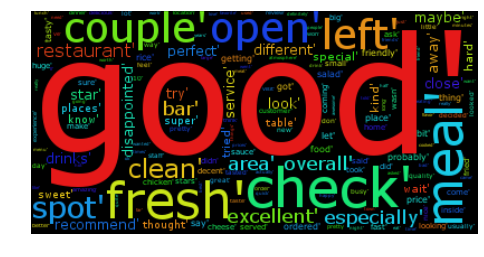

In [19]:
from os import path
from scipy.misc import imread
import matplotlib.pyplot as plt
import random

from wordcloud import WordCloud, STOPWORDS

text = str(cv.get_feature_names())
wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                      relative_scaling = 1.0,
                      stopwords = 'to of'
                      ).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()